# Assignment 3: Implementation, Analysis, Performance Evaluation and Comparison of Deep Convolutional Neural Networks for Image Classification

**Objective:** The objective of this assignment is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion. 

**Tasks:**
To complete this assignment, please submit a single notebook that includes the implementation and outputs of the following seven steps.
Provide answers for each sub-question by thorough analysis and extensive experimental investigation using the provided dataset. In other words, your answers should be backed by experimental analysis of your models and the dataset. Please ensure that the notebook retain the outputs. Failure to do so will result in zero marks for the corresponding steps in which no output is displayed.

**1. Prepare and Preprocess the data. (15 points)**

* What is the total number of images in the dataset, and how are they distributed across the five flower types?

* Do we need to implement techniques to balance the distribution of images across various flower types, such as oversampling or undersampling?

* What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?

* What preprocessing techniques should be applied, such as resizing, normalization or standardization and why?

* How would you split the dataset into training, validation and testing sets, and in what ratios?


In [1]:
#Step 1 implementation
#Hint: Take the help of split-folder python library
import tensorflow as tf
import keras
import pandas as pd
import os
import cv2
# from skimage import io
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# from imblearn.over_sampling import RandomOverSampler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models,optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from keras.models import Model

In [3]:
#Defining the ROOT_PATH and class_names
ROOT_PATH = 'C:/Users/lenovo/Downloads/Assignment3/flowers'
class_names = os.listdir(ROOT_PATH)

In [4]:
'''The data is loaded and preprocessed to make the images data to similar dimensions by the below function'''
# Function to load and preprocess images
def load_and_preprocess_data(root_path, class_names):
    X = []
    y = []

    code = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(root_path, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)

            # Add print statements for debugging
#             print(f"Processing image: {image_path}")
            
            image = cv2.imread(image_path)
            
            # Check if image is loaded successfully
            if image is None:
                print(f"Error loading image: {image_path}")
                continue
            
            image = cv2.resize(image, (224, 224))  # Resize to a common dimension
            image = image / 255.0  # Normalize pixel values
            X.append(image)
            y.append(code[class_name])

    return np.array(X), np.array(y), code


In [27]:
'''Now lets check if our images are of similar dimensions or we need to use the above function to preprocess our image dataset.'''
# Get a list of all image files
all_images = [os.path.join(root, file) for root, dirs, files in os.walk(ROOT_PATH) for file in files]

# Dictionary to store dimensions for each flower type
dimensions_by_type = {}

# Iterate over each image and extract dimensions
for image_path in all_images:
    # Extract flower type from file path
    flower_type = image_path.split(os.path.sep)[-2]
    
    # Open the image and get its dimensions
    with Image.open(image_path) as img:
        width, height = img.size
    
    # Store dimensions in the dictionary
    if flower_type not in dimensions_by_type:
        dimensions_by_type[flower_type] = []
    dimensions_by_type[flower_type].append((width, height))

# Print dimensions of 5 images from each flower type
for flower_type, dimensions_list in dimensions_by_type.items():
    print(f"\nFlower Type: {flower_type}")
    for i in range(min(5, len(dimensions_list))):  # Print dimensions for up to 5 images
        width, height = dimensions_list[i]
        print(f"  Image {i + 1}: Width: {width}, Height: {height}")

# Check for variations
for flower_type, dimensions_list in dimensions_by_type.items():
    unique_dimensions = set(dimensions_list)
    if len(unique_dimensions) > 1:
        print(f"\nThere are variations in dimensions for Flower Type {flower_type}.")
    else:
        print(f"All images of Flower Type {flower_type} have the same dimensions.")


Flower Type: daisy
  Image 1: Width: 320, Height: 263
  Image 2: Width: 500, Height: 313
  Image 3: Width: 320, Height: 215
  Image 4: Width: 500, Height: 333
  Image 5: Width: 320, Height: 250

Flower Type: dandelion
  Image 1: Width: 320, Height: 213
  Image 2: Width: 320, Height: 218
  Image 3: Width: 180, Height: 240
  Image 4: Width: 500, Height: 339
  Image 5: Width: 180, Height: 240

Flower Type: rose
  Image 1: Width: 179, Height: 240
  Image 2: Width: 320, Height: 240
  Image 3: Width: 500, Height: 333
  Image 4: Width: 320, Height: 231
  Image 5: Width: 180, Height: 240

Flower Type: sunflower
  Image 1: Width: 500, Height: 330
  Image 2: Width: 320, Height: 240
  Image 3: Width: 320, Height: 240
  Image 4: Width: 240, Height: 231
  Image 5: Width: 213, Height: 240

Flower Type: tulip
  Image 1: Width: 320, Height: 209
  Image 2: Width: 500, Height: 335
  Image 3: Width: 500, Height: 335
  Image 4: Width: 500, Height: 333
  Image 5: Width: 320, Height: 214

There are variati

Total number of images: 4317
Distribution per class: {'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}


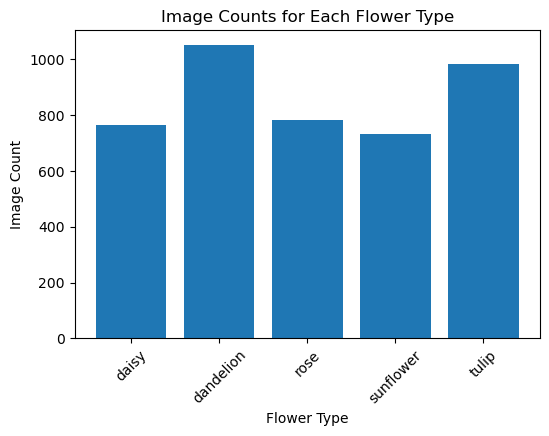

In [5]:
#Since there is variation in dimension of images we will use our function to Load and preprocess data
X, y, code = load_and_preprocess_data(ROOT_PATH, class_names)

# Check the total number of images and their distribution
total_images = len(X)
distribution_per_class = {class_name: np.sum(y == code[class_name]) for class_name in class_names}
print("Total number of images:", total_images)
print("Distribution per class:", distribution_per_class)


# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(distribution_per_class.keys(), distribution_per_class.values())
plt.xlabel('Flower Type')

plt.ylabel('Image Count')
plt.title('Image Counts for Each Flower Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.show()

In [5]:
# We can see that the database is not balanced from the flower count, we can balance by using oversampling or undersampling 
# techniques.
# but that is not working on my system so I have used the class_weights to increase the priority of classes containing less data.

In [6]:
# Split the dataset into training, validation, and testing sets by 70%, 15% and 15% ratio.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print("Image dimensions:", X_train.shape[1:])
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Image dimensions: (224, 224, 3)
Training set size: 3021
Validation set size: 648
Testing set size: 648


In [7]:
#Calculating class weight
class_weights = compute_class_weight( class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train  )
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

**2. Implement the given CNN architecture. Make necessary changes in the final layers for it to work on the number of classes in the given dataset. Use an input image size of $224 \times 224 \times 3$ (10 points)**
<img src='CNN.png' alt='given CNN'>

In [9]:
# # Create a sequential model
# model = keras.Sequential([
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
#     layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(4096, activation='relu'),
#     layers.Dense(4096, activation='relu'),
#     layers.Dense(4096, activation='relu'),
#     layers.Dense(len(class_names), activation='softmax')  # Adjust the output units based on the number of classes
# ])

# Create a sequential model with Batch Normalization as the normal model without it is taking to long to converge and each epoch is taking
# is taking 2 hrs to execute and still not giving good accuracy.
model = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax')  # Adjust the output units based on the number of classes
])


In [10]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

**3. Train the model. (15 Points)** 

* What is your approach for selecting the appropriate hyperparameters for the model training, such as the learning rate, number of epochs, batch size, and optimizer?

* What methods do you use for monitoring the training progress and performance of the model and why?

* What metrics would you prefer to measure the performance, such as accuracy, precision, recall, F1 score, or ROC-AUC and why?

In [11]:
#Step 3 implementation
epochs = 25
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/25
95/95 [==============================] - 1955s 20s/step - loss: 2.7088 - accuracy: 0.3628 - val_loss: 14.5399 - val_accuracy: 0.2423
Epoch 2/25
95/95 [==============================] - 1923s 20s/step - loss: 1.4352 - accuracy: 0.4671 - val_loss: 3.7214 - val_accuracy: 0.2654
Epoch 3/25
95/95 [==============================] - 2961s 31s/step - loss: 1.3090 - accuracy: 0.5058 - val_loss: 3.9606 - val_accuracy: 0.2608
Epoch 4/25
95/95 [==============================] - 1985s 21s/step - loss: 1.3433 - accuracy: 0.5104 - val_loss: 1.8440 - val_accuracy: 0.4012
Epoch 5/25
95/95 [==============================] - 1927s 20s/step - loss: 1.2377 - accuracy: 0.5548 - val_loss: 1.3783 - val_accuracy: 0.5494
Epoch 6/25
95/95 [==============================] - 1922s 20s/step - loss: 1.1563 - accuracy: 0.5773 - val_loss: 1.2166 - val_accuracy: 0.5108
Epoch 7/25
95/95 [==============================] - 1924s 20s/step - loss: 1.2075 - accuracy: 0.5783 - val_loss: 1.1816 - val_accuracy: 0.555

In [12]:
#Saving the baseline model
model.save('model.h5')

In [16]:
from tensorflow.keras.models import load_model

# Load the saved baseline model
baseline_model = load_model('model.h5')

In [10]:
#Training the model for additional 5 epochs
history1 = baseline_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/5
95/95 [==============================] - 1971s 21s/step - loss: 0.7882 - accuracy: 0.7392 - val_loss: 6.0265 - val_accuracy: 0.4707
Epoch 2/5
95/95 [==============================] - 2454s 26s/step - loss: 0.7029 - accuracy: 0.7580 - val_loss: 2.3622 - val_accuracy: 0.4491
Epoch 3/5
95/95 [==============================] - 1952s 21s/step - loss: 0.7074 - accuracy: 0.7683 - val_loss: 1.4318 - val_accuracy: 0.6111
Epoch 4/5
95/95 [==============================] - 1949s 21s/step - loss: 0.6557 - accuracy: 0.7898 - val_loss: 1.5626 - val_accuracy: 0.6065
Epoch 5/5
95/95 [==============================] - 2066s 22s/step - loss: 0.6923 - accuracy: 0.7663 - val_loss: 1.5675 - val_accuracy: 0.6389


In [8]:
#Saving the baseline model
baseline_model.save('model1.h5')

In [9]:
from tensorflow.keras.models import load_model

# Load the saved baseline model
baseline_model = load_model('model1.h5')

In [ ]:
# history1 = baseline_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict)

**4. Report the results. (10 points)**

* What is the final accuracy of the model on the validation set, and how does it compare to the training accuracy?

* What is the confusion matrix for the model on the validation set, and which flower types are the most difficult to classify?

* How does the model perform on individual flower types, and are there any particular images that the model struggles to classify?

* What is the rough model complexity?

* Is the model's large size contributing to any challenges or constraints in its performance on the given dataset.


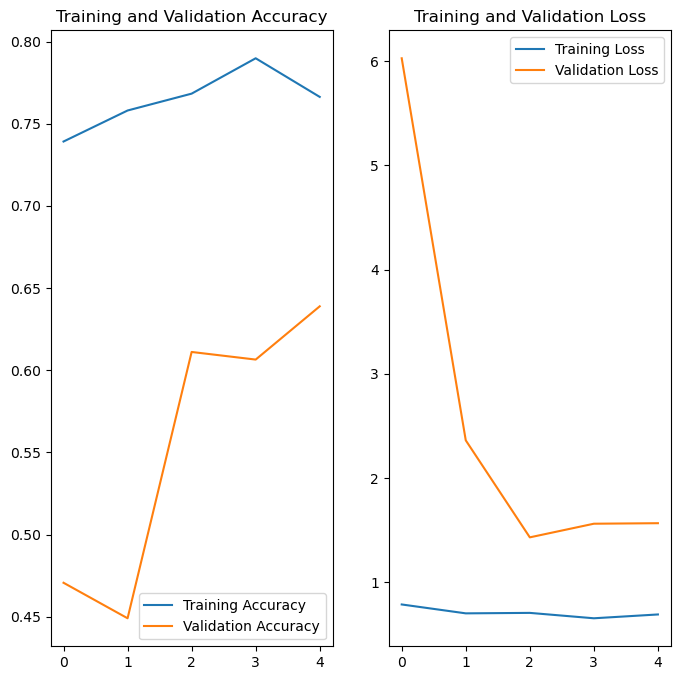

In [16]:
# Traing set vs validation set on last 5 epochs
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# Evaluate the model on the validation set
y_val_pred = baseline_model.predict(X_val)
y_val_classes = np.argmax(y_val_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_classes)
print(f"Test Accuracy: {accuracy}")


21/21 [==============================] - 296s 14s/step
Test Accuracy: 0.6388888888888888



Confusion Matrix for validation set:


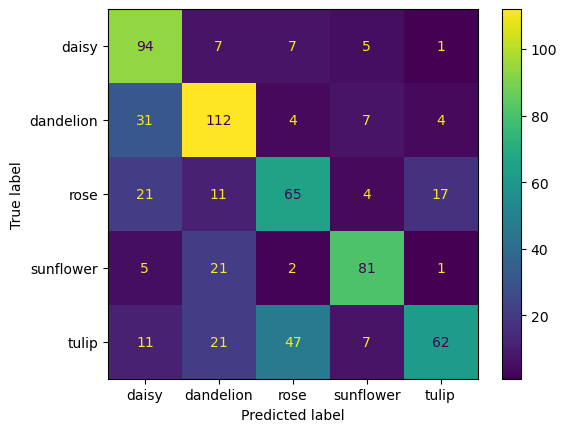

Classification Report for validation set:
              precision    recall  f1-score   support

       daisy       0.58      0.82      0.68       114
   dandelion       0.65      0.71      0.68       158
        rose       0.52      0.55      0.53       118
   sunflower       0.78      0.74      0.76       110
       tulip       0.73      0.42      0.53       148

    accuracy                           0.64       648
   macro avg       0.65      0.65      0.64       648
weighted avg       0.65      0.64      0.63       648



In [14]:
# Confusion matrix for validation set
conf_matrix = confusion_matrix(y_val, y_val_classes)
print("\nConfusion Matrix for validation set:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

'''From the confusion matrix we can see model is having trouble distinguishing the tulip from rose.'''

# Classification report for validation test to see the performance of individual flower categories
class_report = classification_report(y_val, y_val_classes, target_names=class_names)
print("Classification Report for validation set:")
print(class_report)

In [15]:
# Evaluate the model on the testing set
y_pred = baseline_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nTest Accuracy: {accuracy}%\n")

# Compare to training accuracy
train_accuracy = accuracy_score(y_train, np.argmax(baseline_model.predict(X_train), axis=1))
print(f"\nTraining Accuracy: {train_accuracy}%\n")


21/21 [==============================] - 295s 14s/step

Test Accuracy: 0.6219135802469136%

95/95 [==============================] - 1371s 14s/step

Training Accuracy: 0.8053624627606752%



Confusion Matrix for testing set:


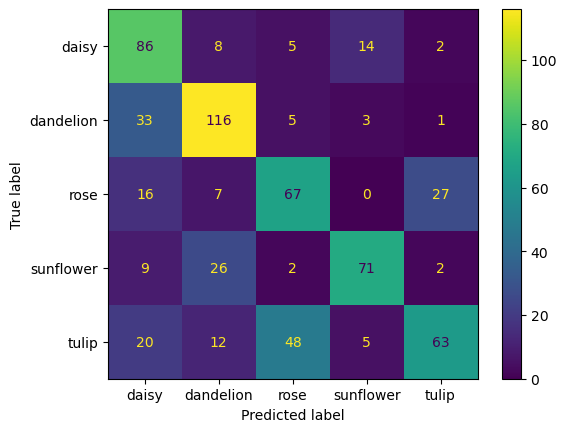

In [16]:
# Confusion matrix for testing set
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix for testing set:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [17]:
# Classification report for testing test to see the performance of individual flower categories
class_report = classification_report(y_test, y_pred_classes, target_names=class_names)
print("Classification Report for testing set:")
print(class_report)

Classification Report for testing set:
              precision    recall  f1-score   support

       daisy       0.52      0.75      0.62       115
   dandelion       0.69      0.73      0.71       158
        rose       0.53      0.57      0.55       117
   sunflower       0.76      0.65      0.70       110
       tulip       0.66      0.43      0.52       148

    accuracy                           0.62       648
   macro avg       0.63      0.63      0.62       648
weighted avg       0.64      0.62      0.62       648



In [43]:
# Print the model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [ ]:
'''This model has lot of parameters which makes training the model harder as each epoch takes 30 - 60 mins to train. Without the
batch normalization layer it was taking 2 hrs per epoch and after executing for 30 epochs the accuracy was only 16% so batch norm
layer was added to to reduce the internal covariant shift and to reach the optimal accuracy faster.'''

**5. Test the model by giving it a picture taken by your own phone camera. (10 points)**

* How can the accuracy of the model on the picture taken by your own phone camera be evaluated?

* What can be done if the model does not perform well on the picture taken by your own phone camera?


In [28]:
#Loading and pre-processing the picture from the folder
X_mobile_test, y_mobile_test, code = load_and_preprocess_data('C:/Users/lenovo/Downloads/Assignment3/mobile_flower', class_names)

#Using the model to predict 
y_mobile_pred = baseline_model.predict(X_mobile_test)
y_mobile_pred_classes = np.argmax(y_mobile_pred, axis=1)



4/4 [==============================] - 16s 4s/step


In [29]:
# Calculate accuracy for mobile dataset
mobile_accuracy = accuracy_score(y_mobile_test, y_mobile_pred_classes)
print(f"Mobile Pictures Test Accuracy: {mobile_accuracy}")

Mobile Pictures Test Accuracy: 0.7321428571428571


Confusion Matrix for mobile data:


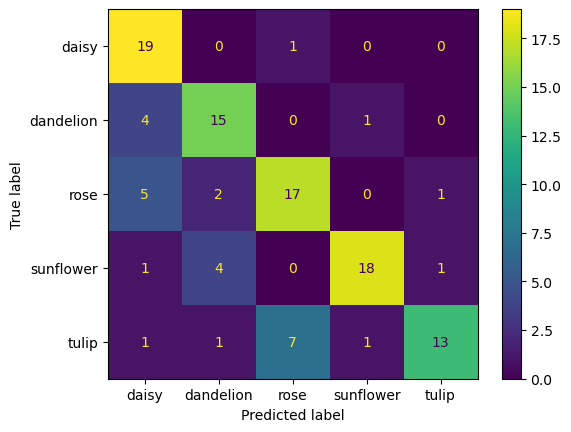


Classification Report for mobile data:
              precision    recall  f1-score   support

       daisy       0.63      0.95      0.76        20
   dandelion       0.68      0.75      0.71        20
        rose       0.68      0.68      0.68        25
   sunflower       0.90      0.75      0.82        24
       tulip       0.87      0.57      0.68        23

    accuracy                           0.73       112
   macro avg       0.75      0.74      0.73       112
weighted avg       0.76      0.73      0.73       112



In [30]:
# Confusion matrix 
conf_matrix = confusion_matrix(y_mobile_test, y_mobile_pred_classes)
print("Confusion Matrix for mobile data:")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

# Classification report to see the performance of individual flower categories
class_report = classification_report(y_mobile_test, y_mobile_pred_classes, target_names=class_names)
print("\nClassification Report for mobile data:")
print(class_report)


In [ ]:
'''To improve the results we can train the model for more tulip dataset to increase the its understanding of tulip, 
we can also add more layers to increase model ability to learn the features more deeply, we can change the models image size,
 as well as we can also increase the no.of epochs to train model more throughly.'''

**6. Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization. (20 points)**


* Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?

* How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?

* What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?

In [38]:
#Step 6 implementation
# L2 regularization model
l2_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(len(class_names), activation='softmax'),
])


In [39]:
# Compile the model
l2_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Print the model summary
l2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [40]:
#Train the l2_model with 10 epochs
history_l2 = l2_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/10
95/95 [==============================] - 1878s 20s/step - loss: 15.8269 - accuracy: 0.2168 - val_loss: 1.6182 - val_accuracy: 0.1698
Epoch 2/10
95/95 [==============================] - 1862s 20s/step - loss: 1.6108 - accuracy: 0.1572 - val_loss: 1.6100 - val_accuracy: 0.1821
Epoch 3/10
95/95 [==============================] - 1856s 20s/step - loss: 1.6098 - accuracy: 0.1956 - val_loss: 1.6095 - val_accuracy: 0.1759
Epoch 4/10
95/95 [==============================] - 1859s 20s/step - loss: 1.6096 - accuracy: 0.1860 - val_loss: 1.6096 - val_accuracy: 0.1759
Epoch 5/10
95/95 [==============================] - 1862s 20s/step - loss: 1.6096 - accuracy: 0.1691 - val_loss: 1.6098 - val_accuracy: 0.1698
Epoch 6/10
95/95 [==============================] - 1861s 20s/step - loss: 1.6096 - accuracy: 0.1870 - val_loss: 1.6096 - val_accuracy: 0.1698
Epoch 7/10
95/95 [==============================] - 1863s 20s/step - loss: 1.6096 - accuracy: 0.1847 - val_loss: 1.6097 - val_accuracy: 0.169

In [41]:
l2_model.save('l2_model.h5')

In [65]:
'''
Performance/ convergence/ size - L2 regularization helps prevent overfitting by penalizing large weights. It is effective 
when the model is prone to overfitting. In this 10 epochs we can see that the loss function is decreasing much faster
than in the original model trained in part 3. 
But the model accuracy is also increasing very slowly which causes slower convergence, but it can improve 
generalization. The model size is nearly same as the base model as the base model uses batch norm, without the batch norm the
base model has around 50,000,000 parameters. 

Inference time - this model takes approximately 20s/step per epoch and per epoch has 95 steps.
To train this model to reach convergence and gives good result we need to increase the number of epochs.'''

'\nPerformance/ convergence/ size - L2 regularization helps prevent overfitting by penalizing large weights. It is effective \nwhen the model is prone to overfitting. In this 10 epochs we can see that the loss function is decreasing much faster\nthan in the original model trained in part 3. \nBut the model accuracy is also increasing very slowly which causes slower convergence, but it can improve \ngeneralization. The model size is nearly same as the base model as the base model uses batch norm, without the batch norm the\nbase model has around 50,000,000 parameters. \n\nInference time - this model takes approximately 20s/step per epoch and per epoch has 95 steps.\nTo train this model we might need to increase the number of epochs.'

In [62]:
'''L2 regularized models weights compared to the baseline model'''
# Getting model weights
baseline_weights = baseline_model.get_weights()
l2_weights = l2_model.get_weights()

#Counter to keep track
count_L2 = 0
count_baseline = 0

# Iterate through corresponding layers and compare L2 norms
for i in range(len(l2_weights)):
    baseline_norm = np.linalg.norm(baseline_weights[i])
    l2_norm = np.linalg.norm(l2_weights[i])

    print(f"Layer {i} - Baseline L2 Norm: {baseline_norm}, L2 Regularized L2 Norm: {l2_norm}")
    

    # Compare the magnitudes
    if l2_norm < baseline_norm:
        print("L2 Regularized Weights have smaller magnitudes.")
        count_L2 += 1
    elif l2_norm > baseline_norm:
        print("Baseline Weights have smaller magnitudes.")
        count_baseline += 1
    else:
        count_L2 += 1
        count_baseline += 1
        print("Magnitudes are equal.")
    print()


Layer 0 - Baseline L2 Norm: 2.6873087882995605, L2 Regularized L2 Norm: 2.520530131278065e-07
L2 Regularized Weights have smaller magnitudes.

Layer 1 - Baseline L2 Norm: 0.2648215889930725, L2 Regularized L2 Norm: 0.04177236184477806
L2 Regularized Weights have smaller magnitudes.

Layer 2 - Baseline L2 Norm: 7.988710880279541, L2 Regularized L2 Norm: 0.0004944562679156661
L2 Regularized Weights have smaller magnitudes.

Layer 3 - Baseline L2 Norm: 0.32686951756477356, L2 Regularized L2 Norm: 0.04746448993682861
L2 Regularized Weights have smaller magnitudes.

Layer 4 - Baseline L2 Norm: 0.8304063081741333, L2 Regularized L2 Norm: 0.0003773271746467799
L2 Regularized Weights have smaller magnitudes.

Layer 5 - Baseline L2 Norm: 0.07764224708080292, L2 Regularized L2 Norm: 0.06265842914581299
L2 Regularized Weights have smaller magnitudes.

Layer 6 - Baseline L2 Norm: 9.236048698425293, L2 Regularized L2 Norm: 0.0009371815831400454
L2 Regularized Weights have smaller magnitudes.

Layer

In [64]:
if count_L2 > count_baseline:
    print("The l2_model learned weights have smaller magnitudes compared to the non-regularized/baseline model. It implies that the model is penalized for having large weights.")
else:
    print("The beseline model learned weights have smaller magnitudes compared to the l2_model model.")

The l2_model learned weights have smaller magnitudes compared to the non-regularized/baseline model. It implies that the model is penalized for having large weights.


In [ ]:
'''I have used batch normalization to train the baseline model to reach convergence to faster as without it the model was
not giving good accuracy even with 30 epochs and has very high loss values. Whereas with batchnorm I am able to get 63% accuracy
on test test and reduce the loss to 1.5 for validation set.'''

In [ ]:
'''
Performance/ convergence/ size: Batch_norm model performs better than the normal model without batch norm in this dataset. 
The convergence time was reduced to 30 - 45 mins per epochs(batch norm) from 1-2 hrs per epoch(without batch norm). The size for
for model without batch_norm was around 50 million parameters whereas for the batch norm its 151 million parameters.

Inference time: this model takes approximately 20s/step per epoch and per epoch has 95 steps.

Weights: The weights may have different distributions, and the normalization during training could 
lead to weights that are closer to zero mean and unit variance.
'''

In [6]:
#Training model with both L2 and batch normalization to check there combined use.
l2_model_with_bn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax'),
])

In [7]:
# Compile the model
l2_model_with_bn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Print the model summary
l2_model_with_bn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [12]:
#Training the model with 5 epochs
history_l2_bn = l2_model_with_bn.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/5
95/95 [==============================] - 2042s 21s/step - loss: 92.7974 - accuracy: 0.3919 - val_loss: 48.4891 - val_accuracy: 0.2438
Epoch 2/5
95/95 [==============================] - 2029s 21s/step - loss: 35.1002 - accuracy: 0.4234 - val_loss: 26.6603 - val_accuracy: 0.1821
Epoch 3/5
95/95 [==============================] - 2066s 22s/step - loss: 21.9858 - accuracy: 0.4194 - val_loss: 18.3535 - val_accuracy: 0.1759
Epoch 4/5
95/95 [==============================] - 3160s 33s/step - loss: 15.7967 - accuracy: 0.3740 - val_loss: 12.8751 - val_accuracy: 0.2130
Epoch 5/5
95/95 [==============================] - 2516s 26s/step - loss: 11.1590 - accuracy: 0.4353 - val_loss: 9.6117 - val_accuracy: 0.2284


In [13]:
l2_model_with_bn.save('l2_model_with_bn.h5')

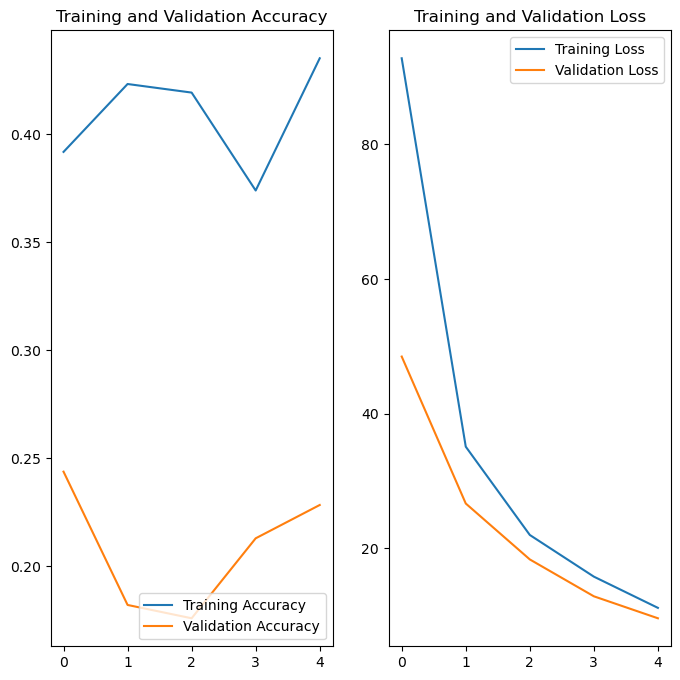

In [24]:
'''We can see that the above model is reducing the loss value pretty quicky and increasing the accuracy slowly but steadly 
for the 5 epochs I trained it for but there is a huge difference between the accuracy of training and validation set. 
It appears the L2 and batch norm compliments each other on this particular dataset once used together atleast for the loss values.
To see the full effect we need to train this model(l2_model_with_bn) for more epochs.'''
#Traing vs Validation set
acc = history_l2_bn.history['accuracy']
val_acc = history_l2_bn.history['val_accuracy']

loss = history_l2_bn.history['loss']
val_loss = history_l2_bn.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
'''In conclusion, both L2 regularization and batch normalization are valuable techniques to improve model performance and
generalization. The choice between them or their combination depends the dataset against which we want to train our data on.
Regularization and normalization techniques are crucial tools in the practitioner's toolbox for building robust
and generalizable machine learning models. To choose the correct technique we can try different combinations of them
and see which one works best for us. To get to the correct model faster we can also try to check pout other people research
and see which combination works best on particular type of dataset.'''


**7. Improve the accuracy by trying something extra. (20 points)** 

* By incorporating additional training strategies such as regularization techniques like dropout, data augmentation, and batch or layer normalization, can the accuracy of the model be improved? 

* Modify the given model architecture to improve the accuracy over the baseline? You can modify the model architecture by adding or removing layers, changing the number of filters, or adding skip connections. 


* Use transfer learning to fine-tune an existing pre-trained model to improve accuracy?  What approach will you use for transfer learning: feature extraction or fine-tuning and why?



In [53]:
#Step 7 implementation
# Adding data augmentation layer
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [54]:
# Define the model with improved architecture
improved_model = models.Sequential([
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax'),
])

In [55]:
# Compile the improved model
improved_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Print the model summary
improved_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_75 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_93 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_76 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_94 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 112, 112, 64)    

In [56]:
# Training the model
history = improved_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/20
95/95 [==============================] - 2022s 21s/step - loss: 138.9229 - accuracy: 0.3158 - val_loss: 80.4222 - val_accuracy: 0.1775
Epoch 2/20
95/95 [==============================] - 1980s 21s/step - loss: 45.6391 - accuracy: 0.3631 - val_loss: 32.1682 - val_accuracy: 0.2284
Epoch 3/20
95/95 [==============================] - 1980s 21s/step - loss: 26.0634 - accuracy: 0.3658 - val_loss: 21.5087 - val_accuracy: 0.2438
Epoch 4/20
95/95 [==============================] - 1975s 21s/step - loss: 18.2191 - accuracy: 0.3787 - val_loss: 18.5977 - val_accuracy: 0.2160
Epoch 5/20
95/95 [==============================] - 1964s 21s/step - loss: 14.5915 - accuracy: 0.3803 - val_loss: 12.9963 - val_accuracy: 0.3148
Epoch 6/20
95/95 [==============================] - 1963s 21s/step - loss: 10.4453 - accuracy: 0.3568 - val_loss: 9.5532 - val_accuracy: 0.2500
Epoch 7/20
95/95 [==============================] - 1966s 21s/step - loss: 7.9233 - accuracy: 0.3731 - val_loss: 22.9690 - val_acc

In [57]:
improved_model.save('improved_model.h5')

In [8]:
# Load the saved improved model to train for 25 more epochs
improved_model = load_model('model.h5')

In [36]:
# Training the model
history = improved_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/25
95/95 [==============================] - 1929s 20s/step - loss: 0.6923 - accuracy: 0.7686 - val_loss: 1.4817 - val_accuracy: 0.6003
Epoch 2/25
95/95 [==============================] - 1917s 20s/step - loss: 0.7864 - accuracy: 0.7468 - val_loss: 2.6426 - val_accuracy: 0.5278
Epoch 3/25
95/95 [==============================] - 3312s 35s/step - loss: 1.1579 - accuracy: 0.6359 - val_loss: 7.3028 - val_accuracy: 0.3904
Epoch 4/25
95/95 [==============================] - 1918s 20s/step - loss: 0.9607 - accuracy: 0.6534 - val_loss: 1.4312 - val_accuracy: 0.5895
Epoch 5/25
95/95 [==============================] - 1918s 20s/step - loss: 0.8267 - accuracy: 0.7190 - val_loss: 1.0758 - val_accuracy: 0.6512
Epoch 6/25
95/95 [==============================] - 1914s 20s/step - loss: 0.8157 - accuracy: 0.7339 - val_loss: 1.4508 - val_accuracy: 0.6065
Epoch 7/25
95/95 [==============================] - 1916s 20s/step - loss: 0.7389 - accuracy: 0.7742 - val_loss: 1.0281 - val_accuracy: 0.6497

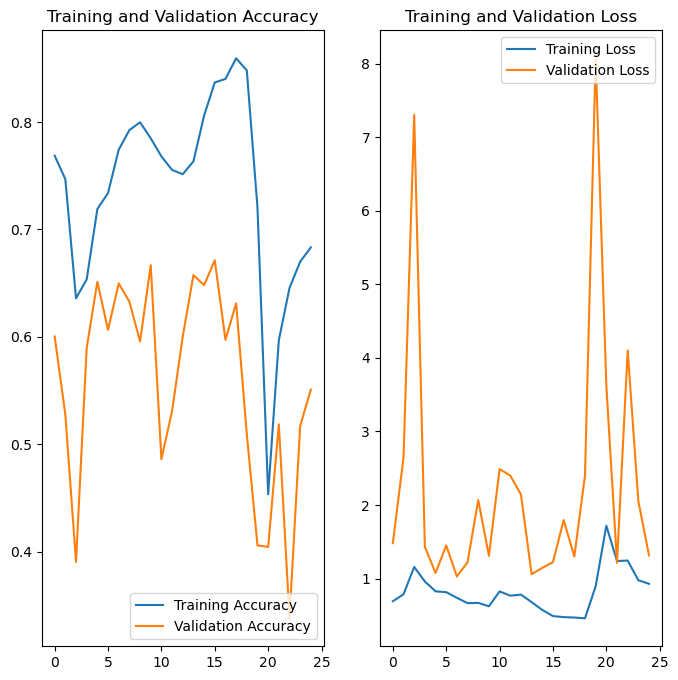

In [41]:
#Traing vs Validation set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
improved_model.save('improved_model1.h5')

In [ ]:
'''There is alot of fluctuations in the accuracy and loss of training and validation set. Overall the batchnorm and L2 regularization
prevent overfitting but using it in combined manner is not working on our dataset. It just causing the model to oscillate back
and forth.'''

In [44]:
#Using the model image dataset to predict 
y_mobile_pred = improved_model.predict(X_mobile_test)
y_mobile_pred_classes = np.argmax(y_mobile_pred, axis=1)

4/4 [==============================] - 9s 2s/step


In [45]:
# Calculate accuracy for mobile dataset
mobile_accuracy = accuracy_score(y_mobile_test, y_mobile_pred_classes)
print(f"Mobile Pictures Test Accuracy: {mobile_accuracy}")

Mobile Pictures Test Accuracy: 0.5089285714285714


In [ ]:
'''Lets try to incoorporate dropout in the baseline model'''

In [8]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a sequential model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4096, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  
])

In [9]:
# Compile the improved model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [10]:
history = model.fit(X_train, y_train,
                    steps_per_epoch=len(X_train)//32,
                    epochs=20,
                    validation_data=(X_val, y_val),class_weight=class_weight_dict)


Epoch 1/20
94/94 [==============================] - 1978s 21s/step - loss: 9.3400 - accuracy: 0.2896 - val_loss: 2.1456 - val_accuracy: 0.2438
Epoch 2/20
94/94 [==============================] - 1957s 21s/step - loss: 1.4336 - accuracy: 0.4130 - val_loss: 1.7751 - val_accuracy: 0.2253
Epoch 3/20
94/94 [==============================] - 1950s 21s/step - loss: 1.3313 - accuracy: 0.4292 - val_loss: 1.6143 - val_accuracy: 0.2670
Epoch 4/20
94/94 [==============================] - 1950s 21s/step - loss: 1.2434 - accuracy: 0.4846 - val_loss: 1.6986 - val_accuracy: 0.2608
Epoch 5/20
94/94 [==============================] - 2478s 26s/step - loss: 1.2309 - accuracy: 0.4934 - val_loss: 1.5437 - val_accuracy: 0.3426
Epoch 6/20
94/94 [==============================] - 1951s 21s/step - loss: 1.2256 - accuracy: 0.4901 - val_loss: 1.2837 - val_accuracy: 0.4599
Epoch 7/20
94/94 [==============================] - 1948s 21s/step - loss: 1.1726 - accuracy: 0.5290 - val_loss: 1.1638 - val_accuracy: 0.5448

In [11]:
model.save('model_bn_dr.h5')

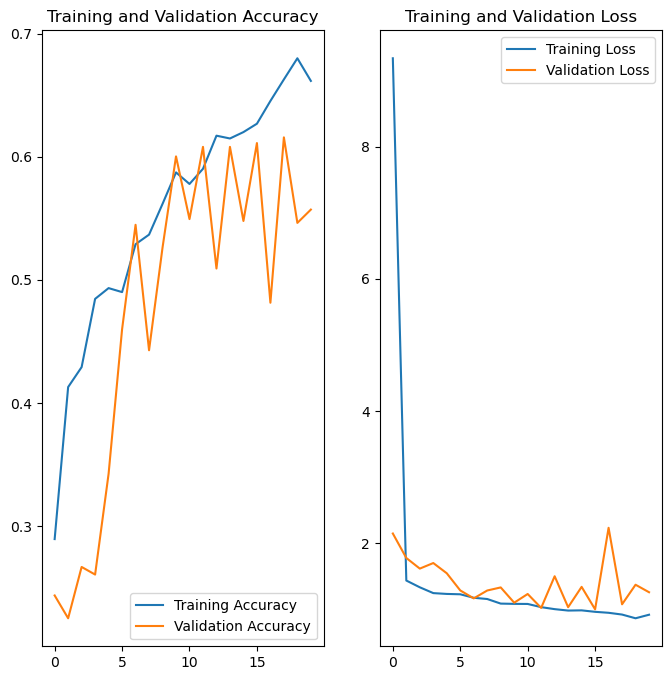

In [12]:
#Traing vs Validation set
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
'''We can see using this model the accuracy increasing for training and validation set as well as loss decreasing for both
the sets. Lets evaluate the result on testing dataset'''

In [22]:
# Evaluate the model on the testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nTest Accuracy: {accuracy}%\n")

'''The testing accuracy improves by using this model. With only 20 epochs the accuracy reaches 68%, whereas for base model
which was trained with 30 epochs, it was 63%. Maybe training this further for few more epochs can improve the models performance
more.'''

19/19 [==============================] - 85s 4s/step

Test Accuracy: 0.685%



In [ ]:
'''For transfer learning we can try using VGG16 or Resnet model.
The convolutional layers can be frozen, and new fully connected layers can be added on top.
Since we have a relatively small dataset for deep learning. 
In this case, it's often a good idea to use feature extraction while leveraging a pre-trained model.'''

In [23]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a sequential model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # Adjust the output units based on the number of flower classes
])


In [24]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                      

In [ ]:
'''Above model can be trained and tested for results, similarly we can also incorporate the Resnet model for transfer learning
approach.'''

In [ ]:
'''Overall, all the techniques mentioned above in the question has effects of improving your models performance,
it just depends on where/how you have incoorporated them and the type of dataset you have and what type of model you are
trying to implement. 
In this dataset incorporating batchnorm and dropout together increases the models efficiency whereas using L2
regularization and batch norm doesnt give good training results.
Another think which I noticed was placement of layers plays a very important role like placing dropout before batchnorm
was increasing the model accuracy but also increasing the loss so I placed batchnorm layer before dropout layer.
This approach works as illustrated above and we can see it increases the accuracy while simultaneouly reducing the loss.'''